### Evaluation notebook

Evaluates on `HPatches` dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import os
from os.path import join, exists, expanduser
from genericpath import isdir
from glob import glob
import numpy as np
from PIL import Image

from lib.r2d2.extract import extract_keypoints_modified
from relfm.utils.paths import REPO_PATH
from relfm.utils.log import print_update, tqdm_iterator
from relfm.utils.visualize import show_images_with_keypoints
from relfm.utils.matching import evaluate_matching_with_rotation, analyze_result
from relfm.inference.r2d2_on_hpatches import configure_save_dir

In [7]:
data_dir = join(REPO_PATH, "data/hpatches-sequences-release/")
model_ckpt_path = join(REPO_PATH, "checkpoints/r2d2_WASF_N16.pt")
output_dir = join(expanduser("~"), "outputs/rotation-equivariant-lfm")

In [14]:
assert isdir(data_dir)
assert isdir(output_dir)
assert exists(model_ckpt_path)

gap_between_rotations=15
imsize=300

In [23]:
save_dir = configure_save_dir(output_dir, model_ckpt_path, dataset_name="hpatches")

In [24]:
save_dir

'/home/lcur1325/outputs/rotation-equivariant-lfm/hpatches/r2d2_WASF_N16'

In [25]:
sequences = glob(join(data_dir, "*"))
rotations = np.arange(0, 360 + 1, gap_between_rotations, dtype=int)

Generating predictions for i_pinard:   0%|          | 0/125 [00:00<?, ?it/s]                                                                 

Image 2 with rotation 0


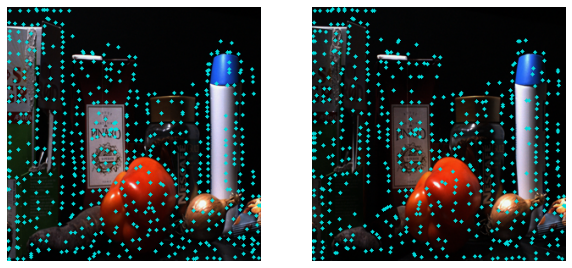

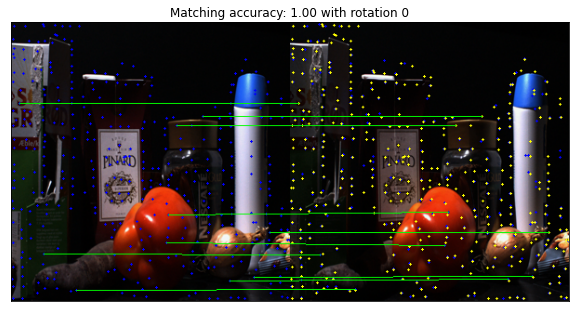

Generating predictions for i_pinard:   0%|          | 0/125 [00:00<?, ?it/s]                                                                 


In [38]:
for sequence in sequences:
    # set path to the source image
    img1_path = join(sequence, "1.ppm")
    img1 = Image.open(img1_path).resize((imsize, imsize))

    # load outputs for source image
    sequence_name = os.path.basename(sequence)
    save_path = join(save_dir, sequence_name, "1.npy")
    img1_outputs = np.load(save_path, allow_pickle=True).item()

    # possible indices of the target images
    img2_indices = np.arange(2, 7)
    # load all target images at once
    img2s = [Image.open(join(sequence, f"{i}.ppm")).resize((imsize, imsize)) for i in img2_indices]

    # load all homographies
    Hs = [np.loadtxt(join(sequence, f"H_1_{i}")) for i in img2_indices]

    rotation_grid, img2_indices_grid  = np.meshgrid(rotations, img2_indices)
    rotation_grid, img2_indices_grid = rotation_grid.flatten(), img2_indices_grid.flatten()

    iterator = tqdm_iterator(range(len(rotation_grid)), desc=f"Generating predictions for {sequence_name}")
    for i in iterator:
        rotation, img2_index = rotation_grid[i], img2_indices_grid[i]
        
        print(f"Image {img2_index} with rotation {rotation}")
        
        if img2_index != 2:
            continue
        
        img2 = img2s[img2_index - 2]
        img2_rotated = img2.rotate(rotation)

        H = Hs[img2_index - 2]

        save_path = join(save_dir, sequence_name, f"{img2_index}_rotation_{rotation}.npy")
        img2_outputs = np.load(save_path, allow_pickle=True).item()
        
        # get keypoints and descriptors from the outputs
        kps1 = img1_outputs["keypoints"]
        des1 = img1_outputs["descriptors"]

        kps2 = img2_outputs["keypoints"]
        des2 = img2_outputs["descriptors"]
        # rotation = img2_outputs["rotation"]
        
        # show detected keypoints
        show_images_with_keypoints([img1, img2_rotated], [kps1, kps2], radius=2)

        # perform matching
        width, height = img2.size
        result = evaluate_matching_with_rotation(
            kp1=kps1,
            des1=des1,
            kp2=kps2,
            des2=des2,
            H=H,
            width=width,
            height=height,
            rotation=rotation,
            return_metadata=True,
            threshold=300.,
        )

        analyze_result(img1, img2_rotated, result, K=10)
        break

    break


### Old code

::::::::::::::::::::::::::::::::::::::::::::::::::::::: Evaluating on 116 sequences. :::::::::::::::::::::::::::::::::::::::::::::::::::::::
Launching on CPU

>> Creating net = Quad_L2Net_ConfCFS()
 ( Model size: 486K parameters )
extracting at scale x1.00 =  800x600
extracting at scale x0.84 =  673x505
extracting at scale x0.71 =  566x424
extracting at scale x0.59 =  476x357
extracting at scale x0.50 =  400x300
extracting at scale x0.42 =  336x252
extracting at scale x0.35 =  283x212
extracting at scale x1.00 =  800x600
extracting at scale x0.84 =  673x505
extracting at scale x0.71 =  566x424
extracting at scale x0.59 =  476x357
extracting at scale x0.50 =  400x300
extracting at scale x0.42 =  336x252
extracting at scale x0.35 =  283x212


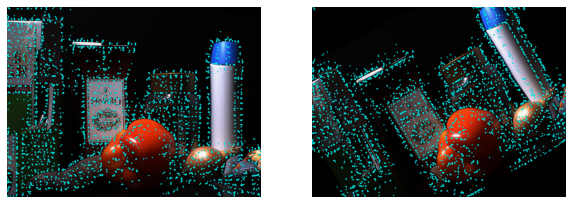

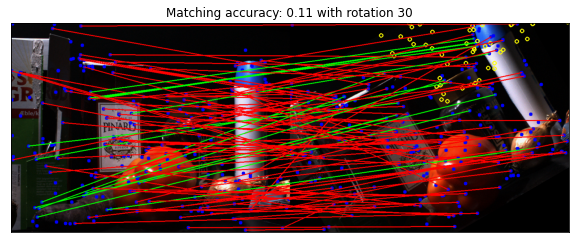

In [7]:
sequences = glob(join(data_dir, "*"))
print_update(f"Evaluating on {len(sequences)} sequences.")
for sequence in sequences:
    # set path to the source image
    img1_path = join(sequence, "1.ppm")
    img1 = Image.open(img1_path)

    # loop over target images
    for i in range(2, 7):
        img2_path = join(sequence, f"{i}.ppm")
        H_path = join(sequence, f"H_1_{i}")
        
        rotation = 30

        img2 = Image.open(img2_path)
        img2 = img2.rotate(rotation)

        H = np.loadtxt(H_path)

        # extract keypoints and descriptors for both images
        outputs = extract_keypoints_modified([img1, img2], model_ckpt_path)

        # get keypoints and descriptors from the outputs
        kps1 = outputs[0]["keypoints"]
        des1 = outputs[0]["descriptors"]

        kps2 = outputs[1]["keypoints"]
        des2 = outputs[1]["descriptors"]

        # show detected keypoints
        show_images_with_keypoints([img1, img2], [kps1, kps2], radius=2)

        # perform matching
        width, height = img2.size
        result = evaluate_matching_with_rotation(
            kp1=kps1,
            des1=des1,
            kp2=kps2,
            des2=des2,
            H=H,
            width=width,
            height=height,
            rotation=rotation,
            return_metadata=True,
            threshold=300.,
        )

        analyze_result(img1, img2, result)
        break
    break